## 1. Setup: Import Libraries and Prepare Data

Building on what we learned in previous exercises.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.1


In [2]:
# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple Silicon GPU (MPS)


In [3]:
# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 938
Test batches: 157


## 2. Define the Model (from Exercise 3)

In [4]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create model and move to device
model = SimpleNN().to(device)
print("Model created and moved to device")
print(model)

Model created and moved to device
SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


## 3. Define Loss Function and Optimizer

**Loss Function**: Measures how wrong the model's predictions are.
- We use `CrossEntropyLoss` for multi-class classification
- It combines softmax and negative log-likelihood

**Optimizer**: Updates the model's parameters to reduce the loss.
- We use `Adam` (Adaptive Moment Estimation)
- Adam is efficient and works well for most problems

In [5]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (learning rate = 0.001)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: {learning_rate}")

Loss function: CrossEntropyLoss()
Optimizer: Adam
Learning rate: 0.001


## 4. Training Function

Let's create a function that trains the model for one epoch.

In [6]:
def train_epoch(model, device, train_loader, optimizer, criterion, epoch):
    """
    Train the model for one epoch.
    
    Returns:
        avg_loss: Average loss for the epoch
        accuracy: Training accuracy for the epoch
    """
    model.train()  # Set model to training mode
    
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Track statistics
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        
        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'  Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, '
                  f'Accuracy: {100. * correct / total:.2f}%')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

print("Training function defined!")

Training function defined!


## 5. Test Function

Let's create a function to evaluate the model on the test set.

In [7]:
def test(model, device, test_loader, criterion):
    """
    Evaluate the model on the test set.
    
    Returns:
        avg_loss: Average loss on test set
        accuracy: Test accuracy
    """
    model.eval()  # Set model to evaluation mode
    
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation during evaluation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

print("Test function defined!")

Test function defined!


## 6. Train the Model!

Now let's train for multiple epochs and track the progress.

In [8]:
# Training settings
num_epochs = 10

# Track history
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print(f"Starting training for {num_epochs} epochs...")
print("=" * 70)

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, device, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Test
    test_loss, test_acc = test(model, device, test_loader, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Print epoch summary
    print(f"\n  Training   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"  Test       - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

end_time = time.time()
training_time = end_time - start_time

print("\n" + "=" * 70)
print(f"Training complete! Total time: {training_time:.2f} seconds")
print(f"Final test accuracy: {test_accuracies[-1]:.2f}%")

Starting training for 10 epochs...

Epoch 1/10
----------------------------------------------------------------------
  Batch 0/938, Loss: 2.3263, Accuracy: 10.94%
  Batch 100/938, Loss: 0.4264, Accuracy: 77.10%
  Batch 200/938, Loss: 0.3287, Accuracy: 83.65%
  Batch 300/938, Loss: 0.1756, Accuracy: 86.25%
  Batch 400/938, Loss: 0.1684, Accuracy: 87.92%
  Batch 500/938, Loss: 0.2534, Accuracy: 89.01%
  Batch 600/938, Loss: 0.2798, Accuracy: 89.94%
  Batch 700/938, Loss: 0.2433, Accuracy: 90.63%
  Batch 800/938, Loss: 0.1424, Accuracy: 91.16%
  Batch 900/938, Loss: 0.2331, Accuracy: 91.60%

  Training   - Loss: 0.2770, Accuracy: 91.78%
  Test       - Loss: 0.1447, Accuracy: 95.77%

Epoch 2/10
----------------------------------------------------------------------
  Batch 0/938, Loss: 0.0440, Accuracy: 98.44%
  Batch 100/938, Loss: 0.1582, Accuracy: 95.93%
  Batch 200/938, Loss: 0.0777, Accuracy: 96.05%
  Batch 300/938, Loss: 0.1237, Accuracy: 96.12%
  Batch 400/938, Loss: 0.1034, Accurac

## 7. Visualize Training Progress

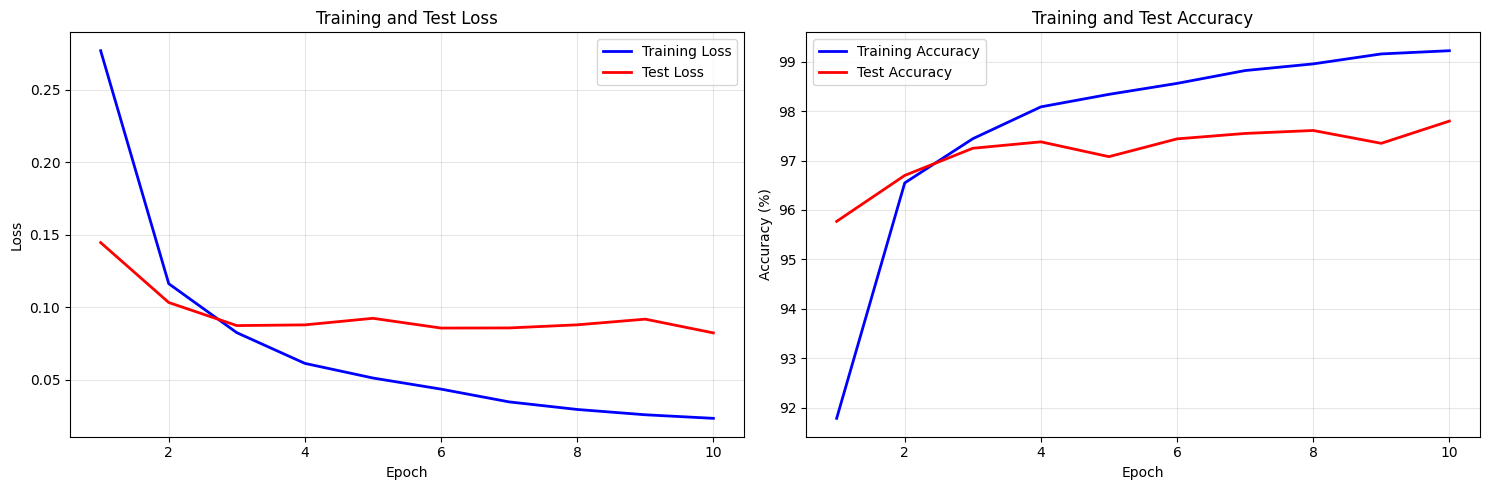


Improvement:
  Test accuracy improved from 95.77% to 97.80%
  Gain: +2.03%


In [9]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(range(1, num_epochs + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, num_epochs + 1), test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nImprovement:")
print(f"  Test accuracy improved from {test_accuracies[0]:.2f}% to {test_accuracies[-1]:.2f}%")
print(f"  Gain: +{test_accuracies[-1] - test_accuracies[0]:.2f}%")

## 8. Test Predictions on Sample Images

Let's see how the trained model performs on some test images.

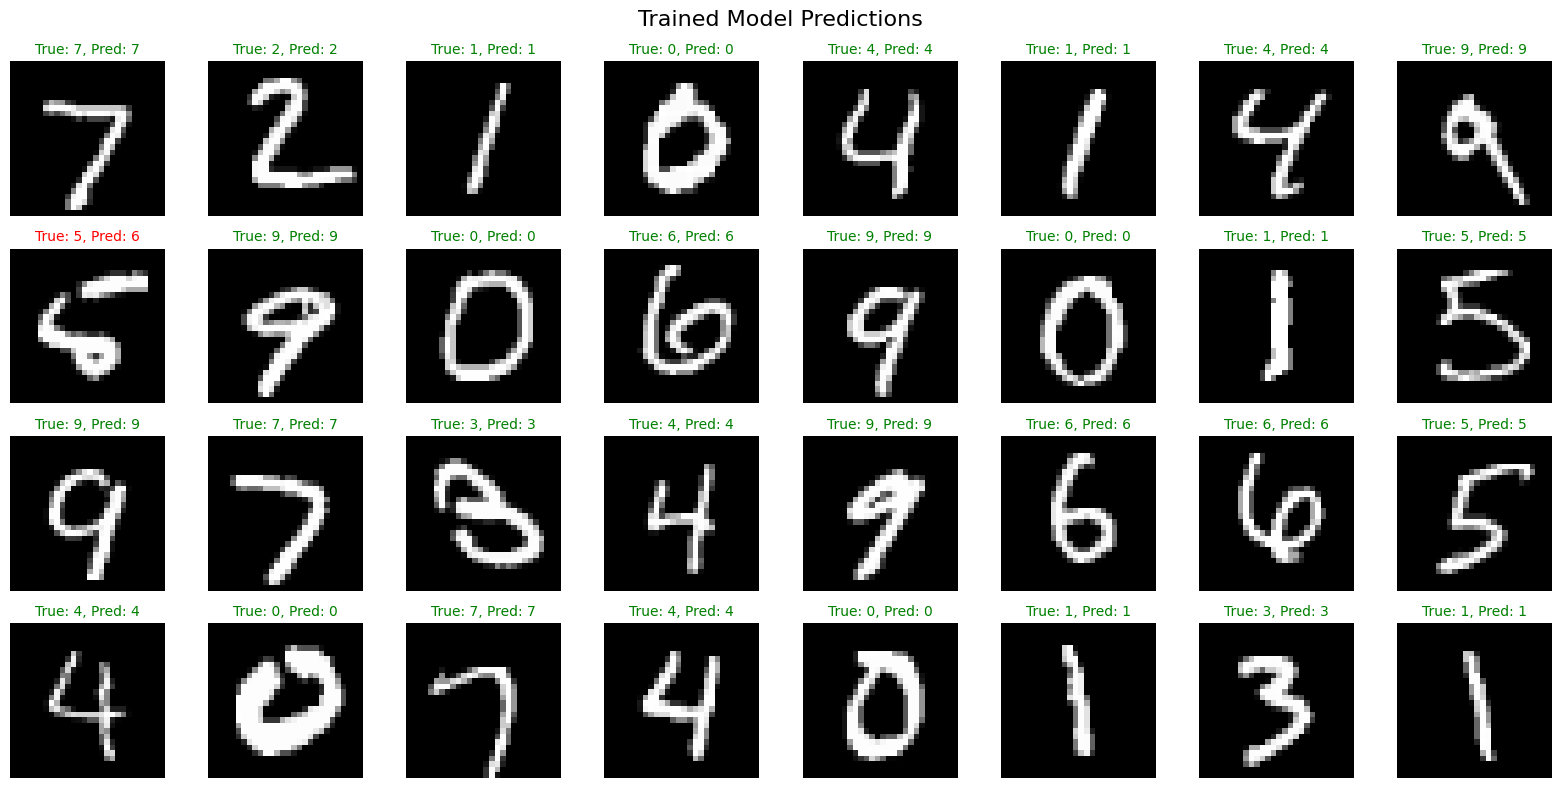


Accuracy on this batch: 63/64 = 98.4%


In [10]:
# Get a batch of test images
test_batch, test_labels = next(iter(test_loader))
test_batch = test_batch.to(device)
test_labels = test_labels.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(test_batch)
    predictions = outputs.argmax(dim=1)

# Visualize predictions
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Trained Model Predictions', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(test_batch):
        image = test_batch[i].cpu().squeeze().numpy()
        true_label = test_labels[i].cpu().item()
        pred_label = predictions[i].cpu().item()
        
        ax.imshow(image, cmap='gray')
        
        # Color: green if correct, red if wrong
        color = 'green' if pred_label == true_label else 'red'
        ax.set_title(f"True: {true_label}, Pred: {pred_label}", color=color, fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Calculate accuracy on this batch
correct = (predictions == test_labels).sum().item()
print(f"\nAccuracy on this batch: {correct}/{len(test_batch)} = {100*correct/len(test_batch):.1f}%")

## 9. Save the Trained Model

Let's save the model so we can use it later without retraining.

In [11]:
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the model
model_path = '../models/mnist_model.pth'
torch.save(model.state_dict(), model_path)

print(f"Model saved to: {model_path}")
print(f"File size: {os.path.getsize(model_path) / 1024:.2f} KB")

Model saved to: ../models/mnist_model.pth
File size: 430.25 KB


In [12]:
# Verify we can load the model back
loaded_model = SimpleNN().to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

print("Model loaded successfully!")

# Test that loaded model gives same predictions
with torch.no_grad():
    test_output = loaded_model(test_batch[:5])
    test_preds = test_output.argmax(dim=1)

print(f"Sample predictions from loaded model: {test_preds.cpu().numpy()}")
print(f"Original predictions:                 {predictions[:5].cpu().numpy()}")
print("\n✓ Loaded model works correctly!")

Model loaded successfully!
Sample predictions from loaded model: [7 2 1 0 4]
Original predictions:                 [7 2 1 0 4]

✓ Loaded model works correctly!


## 10. Summary

Congratulations! You've completed Exercise 4. You now know:

✅ How to define a loss function (CrossEntropyLoss)

✅ How to choose and configure an optimizer (Adam)

✅ How to implement a training loop

✅ How to track training progress (loss and accuracy)

✅ How to evaluate the model on test data

✅ How to visualize training progress

✅ How to save and load trained models

### Key Takeaways

- **Training Loop**: Forward pass → Compute loss → Backward pass → Update weights
- **Loss Function**: CrossEntropyLoss for multi-class classification
- **Optimizer**: Adam efficiently updates weights to minimize loss
- **Epochs**: Multiple passes through the entire dataset
- **Accuracy**: Should reach ~97-98% on MNIST with this simple model

### Training Progress

- Initial accuracy: ~10% (random guessing)
- Final accuracy: ~97-98%
- The model learned to recognize handwritten digits!

### Next Steps

In Exercise 5, we'll evaluate the model more thoroughly with a confusion matrix and analyze where it makes mistakes!